# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет. 

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [1]:
import pandas as pd

In [25]:
df = pd.read_csv('content/persons_pics_train.csv')
df

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,0.237908,0.273203,0.244444,0.332026,0.590850,0.675817,0.684967,0.733333,0.771242,0.771242,...,0.686275,0.694118,0.720261,0.746405,0.756863,0.735948,0.715033,0.684967,0.657516,Tony Blair
1322,0.105882,0.087582,0.117647,0.260131,0.385621,0.466667,0.566013,0.657516,0.692810,0.691503,...,0.722876,0.376471,0.188235,0.139869,0.188235,0.226144,0.243137,0.248366,0.244444,Gerhard Schroeder
1323,0.322876,0.345098,0.369935,0.375163,0.405229,0.464052,0.494118,0.511111,0.517647,0.495425,...,0.465359,0.486274,0.505882,0.535948,0.550327,0.551634,0.552941,0.554248,0.563399,George W Bush
1324,0.304575,0.290196,0.366013,0.444444,0.456209,0.465359,0.479739,0.532026,0.585621,0.603922,...,0.513725,0.802614,0.942484,0.933333,0.707190,0.223529,0.124183,0.133333,0.113725,George W Bush


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [3]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

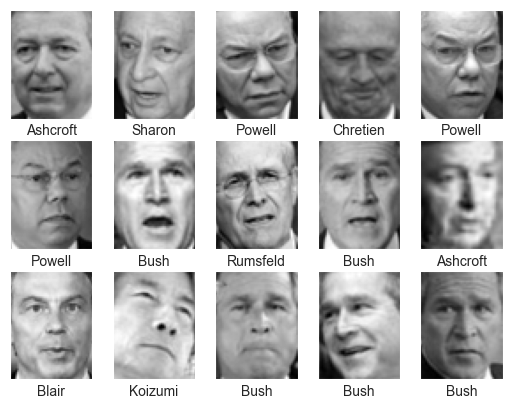

In [4]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

Крупнее

(-0.5, 46.5, 61.5, -0.5)

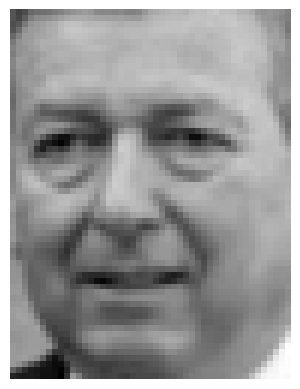

In [5]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [6]:
len(set(df.label))

12

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса.

In [7]:
df_by_person = {}
for name in set(df.label):
    df_by_person[name] = df[df.label == name].drop("label", axis=1)

In [8]:
df_by_person_percentage = { name : array.shape[0]/df.shape[0] for name, array in df_by_person.items()}

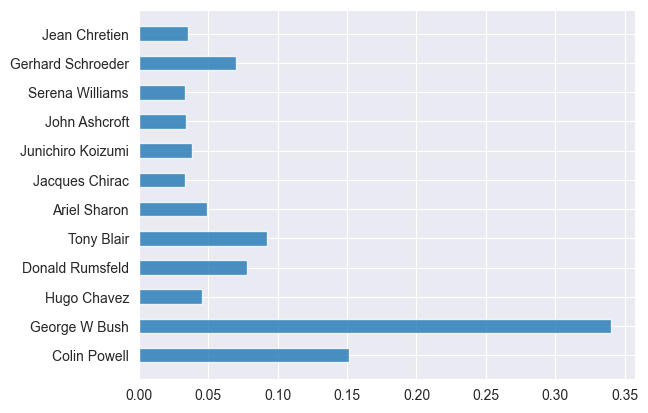

In [9]:
plt.barh(list(df_by_person_percentage.keys()), list(df_by_person_percentage.values()), linewidth=1, alpha=0.8, height=0.5)
None

In [10]:
print(df_by_person_percentage)

{'Colin Powell': 0.1515837104072398, 'George W Bush': 0.3401206636500754, 'Hugo Chavez': 0.04524886877828054, 'Donald Rumsfeld': 0.07767722473604827, 'Tony Blair': 0.09200603318250378, 'Ariel Sharon': 0.049019607843137254, 'Jacques Chirac': 0.033182503770739065, 'Junichiro Koizumi': 0.038461538461538464, 'John Ashcroft': 0.033936651583710405, 'Serena Williams': 0.033182503770739065, 'Gerhard Schroeder': 0.07013574660633484, 'Jean Chretien': 0.03544494720965309}


На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [11]:
df_by_person_mean_vector = {name : vectors.mean(axis=0).astype(float).to_numpy() for name, vectors in df_by_person.items()}

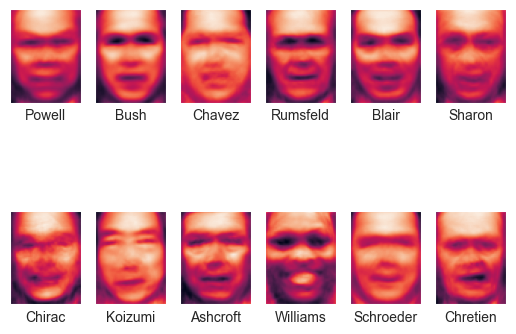

In [12]:
labels = list(df_by_person_mean_vector.keys())

fig, ax = plt.subplots(2, 6)
for i, axi in enumerate(ax.flat):
    lbl = labels[i]
    img = df_by_person_mean_vector[lbl].reshape(62,47)
    axi.imshow(img)
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [13]:
df_by_person_mean_vector['Gerhard Schroeder'][0][0]

IndexError: invalid index to scalar variable.

Используя усредненные векторы, постройте изображения всех людей из набора данных.

In [ ]:
# < ENTER YOUR CODE HERE > 

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [14]:
import numpy as np
import seaborn as sns

sns.set_style('white')

<Axes: >

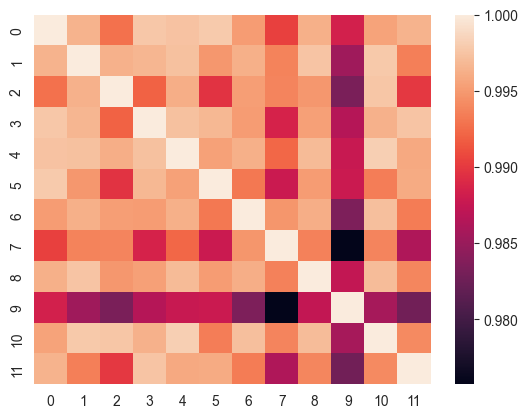

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(np.array(list(df_by_person_mean_vector.values())))
sns.heatmap(similarity_matrix)

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [16]:
list(df_by_person_mean_vector.keys()).index('Gerhard Schroeder')

10

In [17]:
list(df_by_person_mean_vector.keys()).index('Hugo Chavez')

2

In [18]:
similarity_matrix[5][11]

0.9959773533406999

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df.label, test_size=0.2, random_state=7, stratify=df.label)

## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [58]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score

clf = SVC(kernel='linear', random_state=7).fit(X_train, y_train)


Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [59]:
f1_score(y_true=y_test, y_pred=clf.predict(X_test), average='weighted')

0.7414860718599269

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [60]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[7]}]


cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [61]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.769 total time=   1.0s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.769 total time=   1.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.788 total time=   1.0s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.797 total time=   1.0s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.797 total time=   1.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.349 total time=   1.5s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.358 total time=   1.4s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.363 total time=   1.4s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [7]}],
             verbose=3)

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [63]:
cv.best_params_

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'rbf',
 'random_state': 7}

In [62]:
f1_score(y_true=y_test, y_pred=cv.predict(X_test), average='weighted')

0.7669577041760908

## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [99]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver='full').fit(X_train, y_train)

In [100]:
for i, comp in enumerate(pca.explained_variance_ratio_):
    if sum(pca.explained_variance_ratio_[:i]) > 0.95:
        print(i)
        break

181


Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [101]:
pca = PCA(svd_solver='full', n_components=181)
X_train_pca = pca.fit_transform(X_train, y_train)

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [112]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.805 total time=   2.4s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.808 total time=   1.9s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.808 total time=   1.9s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.789 total time=   1.8s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.796 total time=   1.8s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.395 total time=   2.6s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.385 total time=   2.5s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.370 total time=   2.5s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [7]}],
             verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [113]:
cv.best_params_

{'C': 1000,
 'class_weight': None,
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 7}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [86]:
f1_score(y_true=y_test, y_pred=cv.predict(pca.transform(X_test)), average='weighted')

0.7692213234196495

Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.

In [111]:
X_train = df.drop('label', axis=1)
y_train = df.label

In [88]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.782 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.777 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.796 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.755 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.762 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.338 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.340 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.340 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [7]}],
             verbose=3)

In [104]:
cv.best_params_

{'C': 100,
 'class_weight': None,
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 7}

In [114]:
X_test = pd.read_csv('persons_pics_reserved.csv')

In [115]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,0.315033,0.393464,0.517647,0.636601,0.652288,0.653595,0.677124,0.725490,0.716340,0.695425,...,0.031373,0.047059,0.047059,0.053595,0.050980,0.036601,0.027451,0.011765,0.007843,0.003922
1,0.518954,0.664052,0.690196,0.627451,0.576471,0.575163,0.605229,0.633987,0.666667,0.684967,...,0.568627,0.583007,0.577778,0.549020,0.479739,0.403922,0.427451,0.569935,0.772549,0.924183
2,0.196078,0.205229,0.219608,0.197386,0.179085,0.223529,0.295425,0.363399,0.411765,0.471895,...,0.471895,0.479739,0.486274,0.511111,0.528105,0.556863,0.586928,0.611765,0.610458,0.627451
3,0.330719,0.376471,0.413072,0.420915,0.430065,0.454902,0.477124,0.486274,0.487582,0.494118,...,0.688889,0.715033,0.724183,0.695425,0.308497,0.126797,0.125490,0.125490,0.111111,0.109804
4,0.405229,0.428758,0.487582,0.567320,0.619608,0.648366,0.665359,0.686275,0.701961,0.717647,...,0.611765,0.630065,0.627451,0.746405,0.700654,0.200000,0.099346,0.095425,0.087582,0.083660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.435294,0.490196,0.541176,0.601307,0.631373,0.647059,0.681046,0.692810,0.696732,0.720261,...,0.588235,0.586928,0.606536,0.600000,0.654902,0.769935,0.909804,0.986928,0.994771,0.990850
230,0.478431,0.558170,0.601307,0.618301,0.637908,0.649673,0.653595,0.640523,0.630065,0.615686,...,0.128105,0.064052,0.079739,0.091503,0.077124,0.077124,0.074510,0.074510,0.082353,0.086275
231,0.483660,0.474510,0.494118,0.512418,0.529412,0.555556,0.590850,0.626144,0.641830,0.662745,...,0.573856,0.624837,0.707190,0.811765,0.933333,0.985621,0.981699,0.985621,0.989542,0.983007
232,0.284967,0.453595,0.415686,0.384314,0.341176,0.354248,0.407843,0.397386,0.330719,0.324183,...,0.292810,0.301961,0.315033,0.301961,0.390850,0.639216,0.835294,0.904575,0.933333,0.938562


In [108]:
array = ['George W Bush', 'George W Bush', 'Jacques Chirac',
       'Jacques Chirac', 'Tony Blair', 'Colin Powell', 'Donald Rumsfeld',
       'George W Bush', 'Tony Blair', 'Gerhard Schroeder',
       'Donald Rumsfeld', 'Hugo Chavez', 'Tony Blair', 'Hugo Chavez',
       'Colin Powell', 'George W Bush', 'Ariel Sharon', 'Colin Powell',
       'John Ashcroft', 'Gerhard Schroeder', 'Ariel Sharon',
       'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush',
       'Donald Rumsfeld', 'Donald Rumsfeld', 'Tony Blair',
       'Serena Williams', 'Jean Chretien', 'George W Bush',
       'George W Bush', 'George W Bush', 'George W Bush', 'Tony Blair',
       'Colin Powell', 'Donald Rumsfeld', 'Colin Powell', 'George W Bush',
       'Gerhard Schroeder', 'Colin Powell', 'Donald Rumsfeld',
       'Gerhard Schroeder', 'George W Bush', 'Tony Blair',
       'George W Bush', 'George W Bush', 'Gerhard Schroeder',
       'Colin Powell', 'Tony Blair', 'Serena Williams', 'Jean Chretien',
       'Tony Blair', 'George W Bush', 'Colin Powell', 'George W Bush',
       'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush',
       'Gerhard Schroeder', 'Gerhard Schroeder', 'Ariel Sharon',
       'Jean Chretien', 'Tony Blair', 'Ariel Sharon', 'George W Bush',
       'George W Bush', 'Hugo Chavez', 'George W Bush', 'John Ashcroft',
       'George W Bush', 'George W Bush', 'George W Bush', 'Colin Powell',
       'George W Bush', 'George W Bush', 'Colin Powell', 'Tony Blair',
       'Donald Rumsfeld', 'John Ashcroft', 'Donald Rumsfeld',
       'George W Bush', 'Jacques Chirac', 'George W Bush',
       'Serena Williams', 'Colin Powell', 'Jean Chretien', 'Tony Blair',
       'Ariel Sharon', 'Colin Powell', 'George W Bush', 'Colin Powell',
       'Donald Rumsfeld', 'Jacques Chirac', 'Serena Williams',
       'Gerhard Schroeder', 'George W Bush', 'Tony Blair',
       'George W Bush', 'Tony Blair', 'George W Bush', 'George W Bush',
       'George W Bush', 'George W Bush', 'Gerhard Schroeder',
       'George W Bush', 'George W Bush', 'George W Bush', 'John Ashcroft',
       'George W Bush', 'John Ashcroft', 'Junichiro Koizumi',
       'Jacques Chirac', 'George W Bush', 'George W Bush',
       'Donald Rumsfeld', 'Gerhard Schroeder', 'Tony Blair',
       'Ariel Sharon', 'George W Bush', 'George W Bush',
       'Donald Rumsfeld', 'George W Bush', 'George W Bush',
       'Serena Williams', 'Colin Powell', 'Jacques Chirac',
       'George W Bush', 'Junichiro Koizumi', 'Serena Williams',
       'Colin Powell', 'George W Bush', 'Hugo Chavez', 'George W Bush',
       'Donald Rumsfeld', 'George W Bush', 'Tony Blair', 'Colin Powell',
       'Tony Blair', 'Gerhard Schroeder', 'Jacques Chirac',
       'John Ashcroft', 'Gerhard Schroeder', 'George W Bush',
       'George W Bush', 'Colin Powell', 'George W Bush', 'Jacques Chirac',
       'George W Bush', 'Tony Blair', 'Colin Powell', 'Tony Blair',
       'Ariel Sharon', 'Gerhard Schroeder', 'Colin Powell',
       'Donald Rumsfeld', 'George W Bush', 'Jean Chretien',
       'George W Bush', 'Hugo Chavez', 'Colin Powell', 'George W Bush',
       'George W Bush', 'Colin Powell', 'Colin Powell', 'George W Bush',
       'Junichiro Koizumi', 'George W Bush', 'Ariel Sharon',
       'George W Bush', 'Tony Blair', 'Donald Rumsfeld',
       'Junichiro Koizumi', 'George W Bush', 'Tony Blair', 'Tony Blair',
       'Ariel Sharon', 'George W Bush', 'Donald Rumsfeld',
       'George W Bush', 'George W Bush', 'Hugo Chavez', 'Colin Powell',
       'Gerhard Schroeder', 'Ariel Sharon', 'George W Bush',
       'Ariel Sharon', 'Ariel Sharon', 'Donald Rumsfeld', 'Ariel Sharon',
       'George W Bush', 'Tony Blair', 'George W Bush', 'Hugo Chavez',
       'Ariel Sharon', 'Jean Chretien', 'Hugo Chavez', 'Ariel Sharon',
       'Colin Powell', 'George W Bush', 'Colin Powell', 'John Ashcroft',
       'George W Bush', 'Gerhard Schroeder', 'George W Bush',
       'John Ashcroft', 'George W Bush', 'Colin Powell', 'Colin Powell',
       'Donald Rumsfeld', 'Hugo Chavez', 'George W Bush',
       'Gerhard Schroeder', 'Colin Powell', 'George W Bush', 'Tony Blair',
       'Tony Blair', 'George W Bush', 'Tony Blair', 'George W Bush',
       'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush',
       'George W Bush', 'George W Bush', 'Gerhard Schroeder',
       'Colin Powell', 'Colin Powell', 'George W Bush', 'Colin Powell',
       'John Ashcroft', 'Donald Rumsfeld']

In [117]:
cv.predict(X_test)

array(['George W Bush', 'Ariel Sharon', 'Tony Blair', 'Jacques Chirac',
       'Tony Blair', 'Colin Powell', 'Donald Rumsfeld', 'Colin Powell',
       'Tony Blair', 'Gerhard Schroeder', 'Donald Rumsfeld',
       'Hugo Chavez', 'George W Bush', 'Hugo Chavez', 'Colin Powell',
       'George W Bush', 'Ariel Sharon', 'Colin Powell', 'John Ashcroft',
       'Gerhard Schroeder', 'Ariel Sharon', 'George W Bush',
       'Ariel Sharon', 'George W Bush', 'George W Bush',
       'Donald Rumsfeld', 'Donald Rumsfeld', 'Tony Blair',
       'Serena Williams', 'Jean Chretien', 'George W Bush',
       'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush',
       'Colin Powell', 'Donald Rumsfeld', 'Colin Powell', 'George W Bush',
       'Gerhard Schroeder', 'Colin Powell', 'Donald Rumsfeld',
       'Gerhard Schroeder', 'George W Bush', 'Tony Blair',
       'George W Bush', 'George W Bush', 'Tony Blair', 'Colin Powell',
       'Tony Blair', 'Serena Williams', 'Jean Chretien', 'Tony Blair',
 